In [16]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [5]:
x = torch.rand(10,50)
W1 = nn.Parameter(torch.randn(128,50))

print(W1)
print('\n\n')
print(W1.shape)
print(W1.t().shape)
print('\n\n')

y = x@W1.t()
print(y.shape)

Parameter containing:
tensor([[ 1.6922, -1.6276,  0.7524,  ..., -1.0294, -0.4092, -0.7190],
        [-0.5028,  0.9468,  0.4862,  ...,  1.4109, -0.6463,  0.3300],
        [ 1.3448, -0.0880,  1.8760,  ..., -0.2054, -0.1302,  0.2231],
        ...,
        [-0.0490,  0.2554, -0.0321,  ..., -1.5285,  0.0105,  1.2000],
        [ 1.3602,  0.1478,  0.5057,  ..., -2.4922, -0.4768,  1.0201],
        [-2.8521,  0.5810,  0.7499,  ...,  1.8571, -1.5558,  0.9365]],
       requires_grad=True)



torch.Size([128, 50])
torch.Size([50, 128])



torch.Size([10, 128])


In [12]:
W2 = nn.Linear(128, 50)

print(W2)
print('\n\n')

print(W2.weight.shape)
print(W2.weight.t().shape)
print('\n\n')

y = x@W2.weight
print(y.shape)

Linear(in_features=128, out_features=50, bias=True)



torch.Size([50, 128])
torch.Size([128, 50])



torch.Size([10, 128])


In [13]:
print(W1.shape)
print(W2.weight.shape)

torch.Size([128, 50])
torch.Size([50, 128])


In [14]:
dir(nn.Linear)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_get_backward_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'get_buffer',
 'get_extra_state',
 'get_parameter',
 'get_submodule'

In [17]:
data_frame = pd.read_csv('../ANN_part2/mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


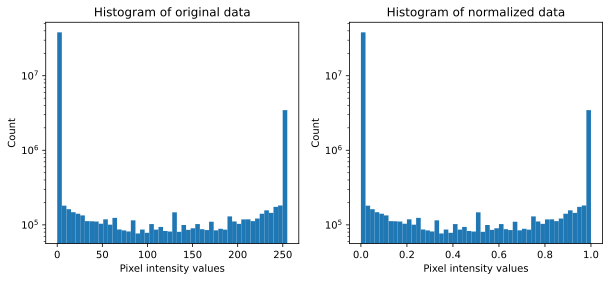

In [18]:
# normalize data to a range of [0, 1]
data_norm = data / np.max(data)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [19]:
dataT = torch.tensor(data_norm).float()

In [20]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,128)
            
            self.enc = nn.Parameter(torch.randn(50, 128))
            
#             self.lat = nn.Linear(50, 250)
            
            self.dec = nn.Linear(128, 784)
            
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = x.t()
            x = F.relu(self.enc@x)
            x = F.relu(self.enc.t()@x)
            x = x.t()
            
            y = torch.sigmoid(self.dec(x))
            
            return y
        
    model = MnistNet()
    
    loss_fun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    
    return model, loss_fun, optimizer

In [21]:
model, loss_fun, optimizer = create_model()

X = dataT[:5, :]
yHat = model(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


In [22]:
num_of_epochs = 10000
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)

    
    for epoch in range(num_of_epochs):
        
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx, :]
                
        yHat = model(X)
        loss = loss_func(yHat, X)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        losses[epoch] = loss.item()
        
    return losses, model

Final loss: 0.0170


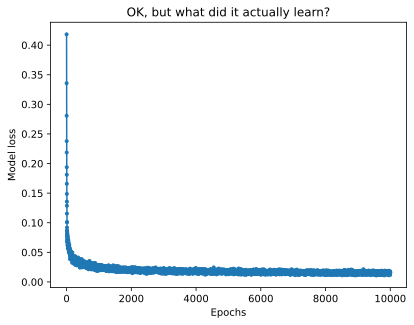

In [23]:
losses, model = train_model()

print(f"Final loss: {losses[-1]:.4f}")

plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn?')
plt.show()

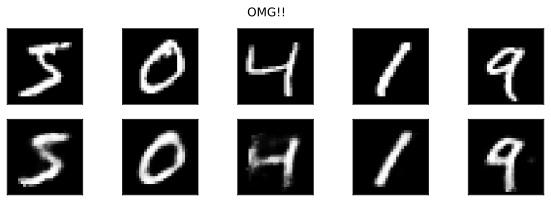

In [24]:
X = dataT[:5, :]
yHat = model(X)

fig, axs = plt.subplots(2, 5, figsize=(10, 3))
for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    
plt.suptitle('OMG!!')
plt.show()

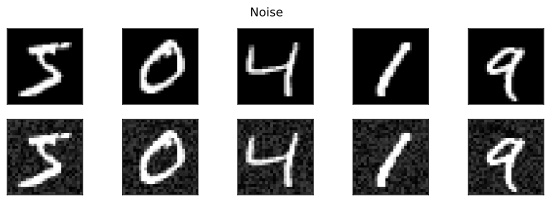

In [26]:
X = dataT[:10, :]
X_noise = X + torch.rand_like(X)/4

X_noise[X_noise>1] = 1


fig, axs = plt.subplots(2, 5, figsize=(10, 3))
for i in range(5):
    axs[0, i].imshow(X[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(X_noise[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    
plt.suptitle('Noise')
plt.show()

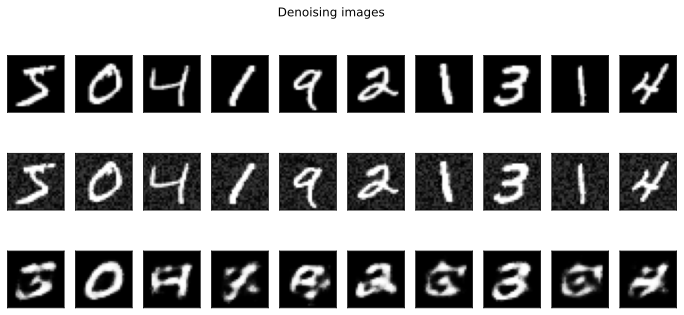

In [27]:
Y = model(X_noise)

fig, axs = plt.subplots(3, 10, figsize=(12, 5))
for i in range(10):
    axs[0, i].imshow(X[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(X_noise[i, :].view(28, 28).detach(), cmap='gray')
    axs[2, i].imshow(Y[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])
    
plt.suptitle('Denoising images')
plt.show()